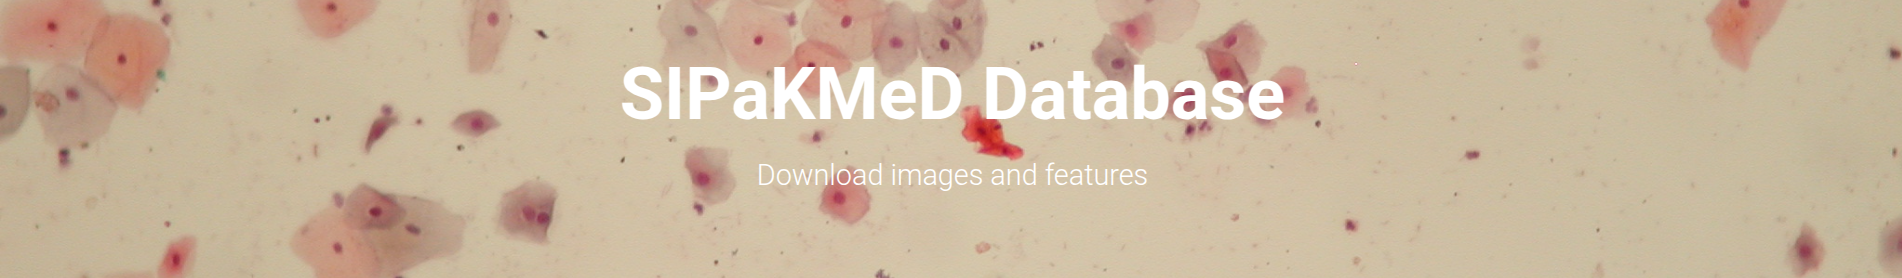

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath('..'))


from Preprocessing.preprocessing import split_data
from tqdm import tqdm

**01. Load & Explore the Data**

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import numpy as np

DATASET_PATH = "../Datasets/SIPaKMeD"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
OUTPUT_FEATURES_PATH = "../Feature_Extraction"

def load_dataset(dataset_path):
    """
    Loads the dataset by scanning directories for `.bmp` images.
    Returns:
    - file_paths: Dict with class names as keys and list of image paths as values
    - class_counts: Dict with class names as keys and count of images as values
    """
    file_paths = {}
    class_counts = {}

    for class_name in sorted(os.listdir(dataset_path)):  
        class_dir = os.path.join(dataset_path, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            bmp_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".bmp")]
            file_paths[class_name] = bmp_files
            class_counts[class_name] = len(bmp_files)

    return file_paths, class_counts

def visualize_class_distribution(class_counts):
    """
    Plots a bar chart showing class distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Class Distribution in SIPaKMeD Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=20)
    plt.show()
    
    

def plot_sample_images(file_paths, num_samples=5):
    """
    Plots sample images from each class.
    """
    fig, axes = plt.subplots(len(file_paths), num_samples, figsize=(num_samples * 2, len(file_paths) * 2))

    for i, (class_name, paths) in enumerate(file_paths.items()):
        sample_paths = np.random.choice(paths, num_samples, replace=False) if len(paths) >= num_samples else paths
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


Class Counts: {'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


/tmp/ipykernel_99402/3771611738.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


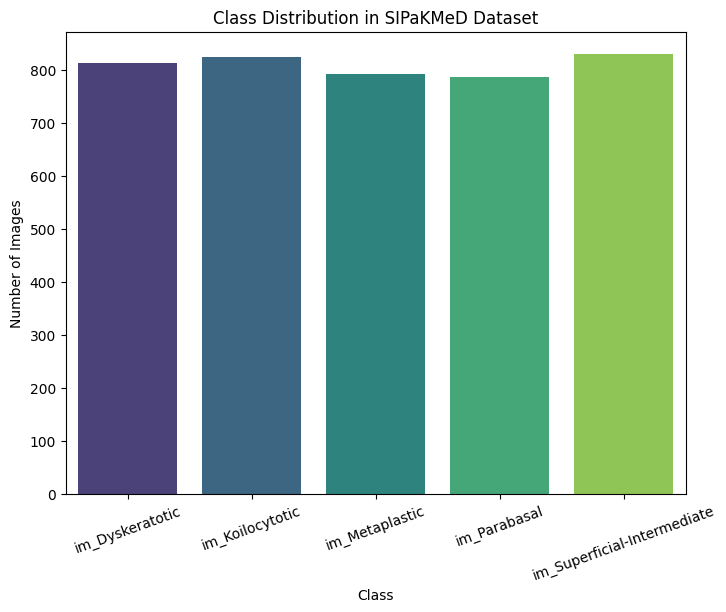

In [4]:
file_paths, class_counts = load_dataset(DATASET_PATH)
print(f"Class Counts: {class_counts}")
visualize_class_distribution(class_counts)


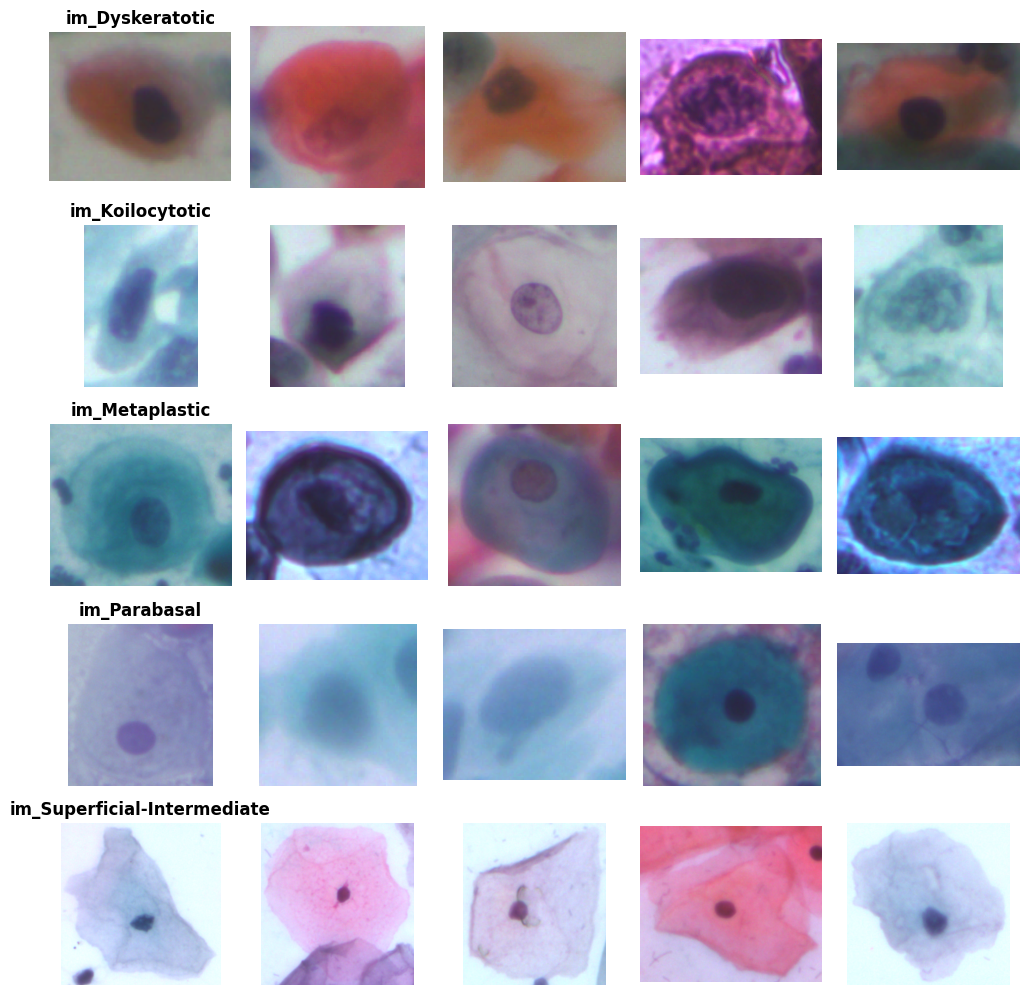

In [5]:
plot_sample_images(file_paths, num_samples=5)

**02. Data Preprocessing.**

* split data

In [76]:
!python ../Datasets/split.py

Class: im_Dyskeratotic → Total images: 813
Class: im_Parabasal → Total images: 787
Class: im_Superficial-Intermediate → Total images: 831
Class: im_Koilocytotic → Total images: 825
Class: im_Metaplastic → Total images: 793
Dataset split into train, cal, val, and test sets successfully.
Total images processed: 4049
Data split successfully into train, cal, val, and test sets.


**03. Feature Extraction**

* 3.1 Models for extraction

* `ResNet5`
* `VGG_Lite`
* `InceptionV3`
* `EfficientNetB7`

In [77]:
!python ../Preprocessing/extractors.py


[INFO] Running feature extraction using 4 parallel processes...

[INFO] Starting feature extraction: ResNet50 | train

[INFO] Starting feature extraction: ResNet50 | cal

[INFO] Starting feature extraction: ResNet50 | val

[INFO] Starting feature extraction: ResNet50 | test
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after progra

**04. Feature visualization (PCA/t-SNE)**


- How separable the features are across classes.

- The effectiveness of ResNet50 vs. DenseNet121 in feature extraction.

- How well the extracted features preserve class structure.

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

FEATURES_PATH = "../Feature_Extraction"

def load_extracted_features(model_name, split_name='train'):
    feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split_name}_features.npy")
    label_path = os.path.join(FEATURES_PATH, f"{split_name}_labels.npy")
    
    X = np.load(feature_path)
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    y = np.load(label_path)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

FEATURES_PATH = "../Feature_Extraction"

def visualize_tsne(models=["ResNet50", "DenseNet121"], split="train", perplexity=30, n_iter=1000, n_pca=50):
    """
    Generates side-by-side t-SNE visualizations for different models with class colors.

    Parameters:
    - models: List of model names whose features to visualize.
    - split: Dataset split to visualize (default is "train").
    - perplexity: t-SNE perplexity parameter (default=30).
    - n_iter: Number of t-SNE iterations (default=1000).
    - n_pca: Number of PCA components before applying t-SNE (default=50).

    The function automatically loads features, applies PCA, then t-SNE, and plots results.
    """
    fig, axes = plt.subplots(1, len(models), figsize=(7 * len(models), 6))

    if len(models) == 1:
        axes = [axes]

    label_path = os.path.join(FEATURES_PATH, f"{split}_labels.npy")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Labels file not found: {label_path}")
    y_labels = np.load(label_path)
    
    # Define color palette for classes
    num_classes = len(np.unique(y_labels))
    palette = sns.color_palette("husl", num_classes)

    for i, model_name in enumerate(models):
        feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split}_features.npy")
        
        if not os.path.exists(feature_path):
            print(f"Skipping {model_name}: Feature file not found: {feature_path}")
            continue
        
        X_features = np.load(feature_path)

        if len(X_features.shape) > 2:
            X_features = X_features.reshape(X_features.shape[0], -1)

        pca = PCA(n_components=n_pca)
        X_pca = pca.fit_transform(X_features)

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        X_tsne = tsne.fit_transform(X_pca)

        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette=palette, alpha=0.7, ax=axes[i])
        axes[i].set_title(f"t-SNE Visualization - {model_name}")
        axes[i].set_xlabel("t-SNE Component 1")
        axes[i].set_ylabel("t-SNE Component 2")

    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()



/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


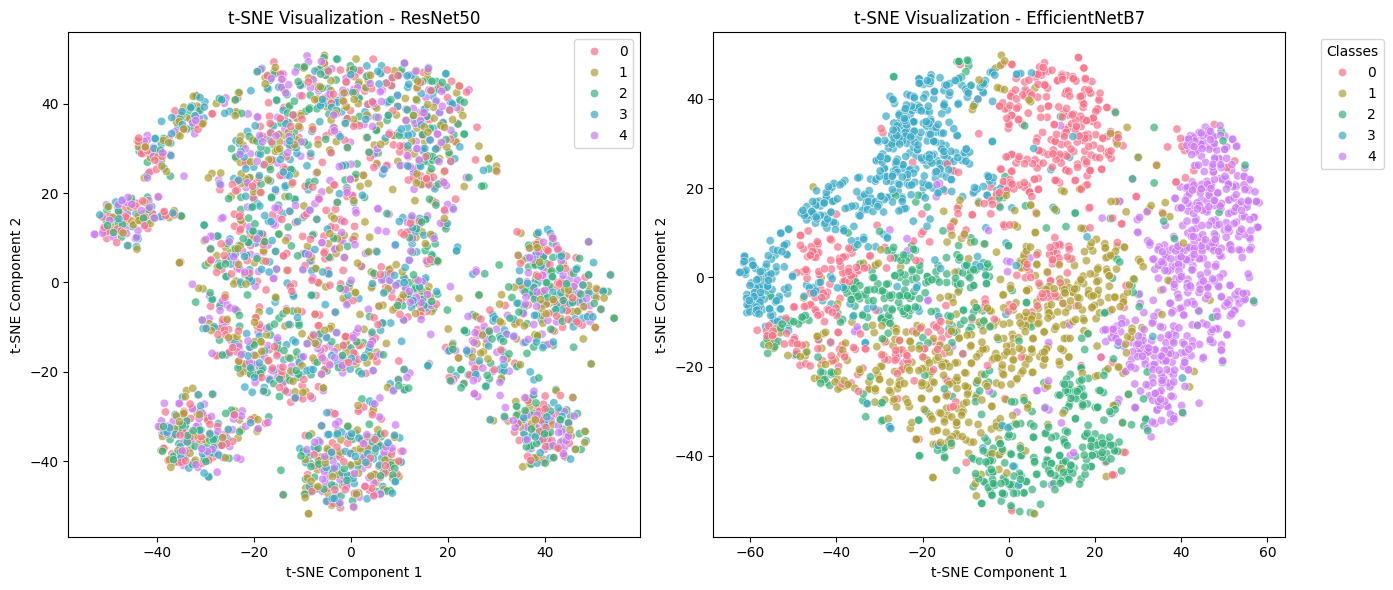

In [79]:
visualize_tsne(models=["ResNet50", "EfficientNetB7"])



In [ ]:
import matplotlib.pyplot as plt
import json


def load_metrics(path="..Outputs/models/EfficientNetB7_baseline_metrics.json"):
    """
    Loads training metrics from saved JSON file.
    """
    
    with open(path, "r") as f:
        metrics = json.load(f)
    
    return metrics



def plot_metrics(metrics, model_name="Model"):
    """
    Plots training and validation loss and accuracy over epochs.
    """
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Over Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy Over Epochs")
    plt.legend()

    plt.show()

**Find best hyperparameters**

In [ ]:
import pandas as pd

df = pd.read_csv("./../Outputs/results/hyperparameter_results.csv")
best_config = df.sort_values(by="accuracy_single", ascending=False).head(5)
best_config


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df.pivot_table(values="accuracy_single", index="batch_size", columns="learning_rate")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Single Network Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.show()
